In [145]:
from xgboost import XGBClassifier
import shap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score


In [146]:
X_train = pd.read_csv('X_train.csv')
X_val = pd.read_csv('X_val.csv')
y_train = pd.read_csv('y_train.csv')
y_val = pd.read_csv('y_val.csv')

In [147]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[12:32:28] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [148]:
y_pred = model.predict(X_val)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 64.41%


In [149]:
def eval_metrics(X,Y):
    ac = accuracy_score(X,Y) * 100
    cm = confusion_matrix(X,Y)
    ps = precision_score(X,Y)
    rs = recall_score(X,Y)
    ss = f1_score(X,Y)
    return ac, cm, ps, rs, ss
    print(f"""accuracy: {ac},\nconfusion matrix: {cm}, \nprecision score: {ps}, recall score: {rs}, f1 score: {ss}""")

In [150]:
eval_metrics(y_val,predictions)

(64.41416893732969,
 array([[ 724, 1287],
        [ 672, 2822]]),
 0.686785105865174,
 0.8076702919290212,
 0.7423385505721426)

In [151]:
from sklearn import metrics
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    print(f"ROC_AUC Score = {roc_auc*100}")
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')

ROC_AUC Score = 58.38450912653559


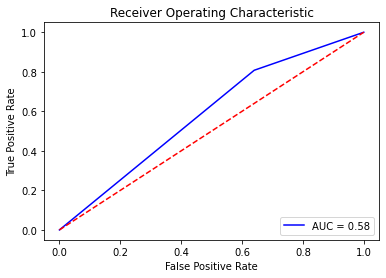

In [152]:
buildROC(y_val,predictions)

In [153]:
#Hyperparamater tuning
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
import xgboost as xgb
import warnings

data = []

def objective(space):

    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    classifier = xgb.XGBClassifier(n_estimators = space['n_estimators'],
                            max_depth = int(space['max_depth']),
                            learning_rate = space['learning_rate'],
                            gamma = space['gamma'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree = space['colsample_bytree'],
                            use_label_encoder=False
                            )
    
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_val)
    predictions = [round(value) for value in y_pred]
    ac, cm, ps, rs, ss = eval_metrics(y_val,predictions)
    fpr, tpr, threshold = metrics.roc_curve(y_val,predictions)

    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
    CrossValMean = accuracies.mean()
    roc_auc = metrics.auc(fpr, tpr) * 100
    print("CrossValMean:", CrossValMean)
    results = {'n_estimators': space['n_estimators'],
                            'max_depth':int(space['max_depth']),
                            'learning_rate':space['learning_rate'],
                            'gamma' : space['gamma'],
                            'min_child_weight': space['min_child_weight'],
                            'subsample': space['subsample'],
                            'colsample_bytree' : space['colsample_bytree'],
                            'use_label_encoder':'False',
               'loss':1-CrossValMean,
               'accuracy':ac,
               'precision score':ps,
               'recall score': rs,
               'f1_score':ss,
               'auc':roc_auc
              }
    data.append(results)
    return{'loss':1-CrossValMean, 'status': STATUS_OK }

space = {
    'max_depth' : hp.choice('max_depth', range(5, 30, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators' : hp.choice('n_estimators', range(20, 205, 5)),
    'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.01),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("Best: ", best)

[12:32:31] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:32:32] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:32:33] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:32:33] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: 

In [154]:
results_frame = pd.DataFrame(data)

In [155]:
results_frame.sort_values(by=['loss']).to_csv('results_xgb(1).csv')

In [156]:
results_frame.to_csv('results_xgb(1).csv')

In [157]:
classifier = XGBClassifier(n_estimators = best['n_estimators'],
                            max_depth = best['max_depth'],
                            learning_rate = best['learning_rate'],
                            gamma = best['gamma'],
                            min_child_weight = best['min_child_weight'],
                            subsample = best['subsample'],
                            colsample_bytree = best['colsample_bytree']
                            )

classifier.fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[12:52:02] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.93, gamma=0.02, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=7,
              min_child_weight=8.0, missing=nan, monotone_constraints='()',
              n_estimators=26, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.33,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [158]:
y_pred = classifier.predict(X_val)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 63.63%


ROC_AUC Score = 54.255017552288976


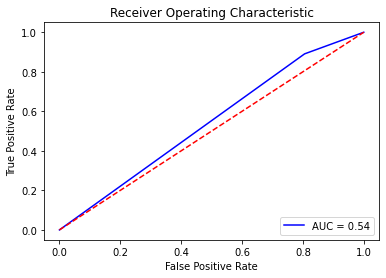

In [159]:
buildROC(y_val,predictions)

In [160]:
from xgboost import plotting
import xgboost

<AxesSubplot:>

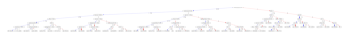

In [161]:
plotting.plot_tree(model,f=12)

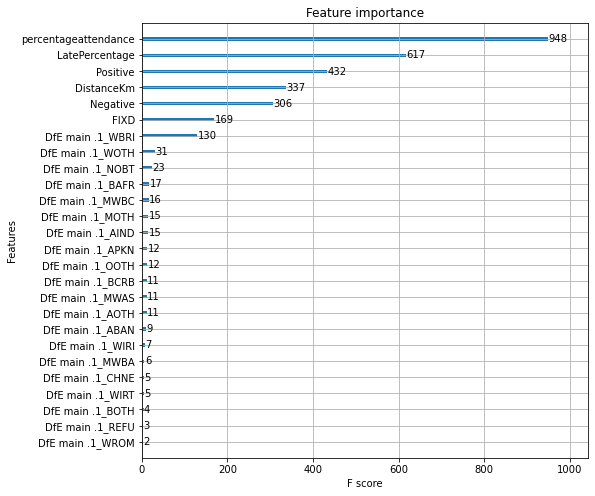

In [162]:
ax = xgboost.plot_importance(model)
fig = ax.figure
fig.set_size_inches(8, 8)

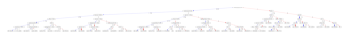

In [163]:
ax_t = xgboost.plotting.plot_tree(model)

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.02672
Feature: 7, Score: 0.05580
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.03154
Feature: 10, Score: 0.04615
Feature: 11, Score: 0.06977
Feature: 12, Score: 0.14101
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.03481
Feature: 15, Score: 0.04837
Feature: 16, Score: 0.01826
Feature: 17, Score: 0.02930
Feature: 18, Score: 0.02423
Feature: 19, Score: 0.03408
Feature: 20, Score: 0.02136
Feature: 21, Score: 0.00890
Feature: 22, Score: 0.03555
Feature: 23, Score: 0.02522
Feature: 24, Score: 0.03849
Feature: 25, Score: 0.02287
Feature: 26, Score: 0.04207
Feature: 27, Score: 0.02489
Feature: 28, Score: 0.02255
Feature: 29, Score: 0.08828
Feature: 30, Score: 0.02512
Feature: 31, Score: 0.00849
Feature: 32, Score: 0.03108
Feature: 33, Score: 0.04511


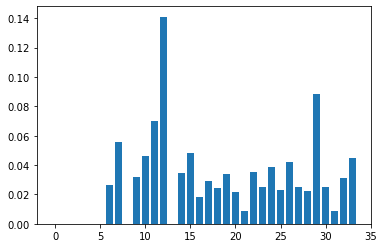

In [164]:
# get importance
importance = model.feature_importances_
# summarise feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [165]:
%%timeit
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)
shap_values

566 ms ± 70.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [166]:
shap_values

array([[ 0.        ,  0.        ,  0.        , ...,  0.00030236,
        -0.00344694,  0.00012066],
       [ 0.        ,  0.        ,  0.        , ...,  0.00030261,
        -0.01080522,  0.00072751],
       [ 0.        ,  0.        ,  0.        , ...,  0.00031852,
        -0.00411351,  0.00012066],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.00030311,
         0.03750761,  0.00023332],
       [ 0.        ,  0.        ,  0.        , ...,  0.00033344,
        -0.00373996,  0.00066976],
       [ 0.        ,  0.        ,  0.        , ...,  0.00029018,
        -0.01393646,  0.00023675]], dtype=float32)

In [170]:
X_val.iloc[0]

EAL                      0.00
Gender                   0.00
MedicalFlag              0.00
PPIndicator              0.00
SafeGuarding             0.00
SENIndicator             0.00
DistanceKm               0.00
LatePercentage           3.92
StartedLate              0.00
Positive                 0.00
Negative                 0.00
FIXD                     0.00
percentageattendance    92.81
summerborn               0.00
DfE main .1_ABAN         0.00
DfE main .1_AIND         0.00
DfE main .1_AOTH         0.00
DfE main .1_APKN         0.00
DfE main .1_BAFR         0.00
DfE main .1_BCRB         0.00
DfE main .1_BOTH         0.00
DfE main .1_CHNE         0.00
DfE main .1_MOTH         0.00
DfE main .1_MWAS         0.00
DfE main .1_MWBA         0.00
DfE main .1_MWBC         0.00
DfE main .1_NOBT         0.00
DfE main .1_OOTH         0.00
DfE main .1_REFU         0.00
DfE main .1_WBRI         1.00
DfE main .1_WIRI         0.00
DfE main .1_WIRT         0.00
DfE main .1_WOTH         0.00
DfE main .

In [171]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_val.iloc[0], plot_cmap=["#39ba34","#d15643"], figsize=(1, 30))

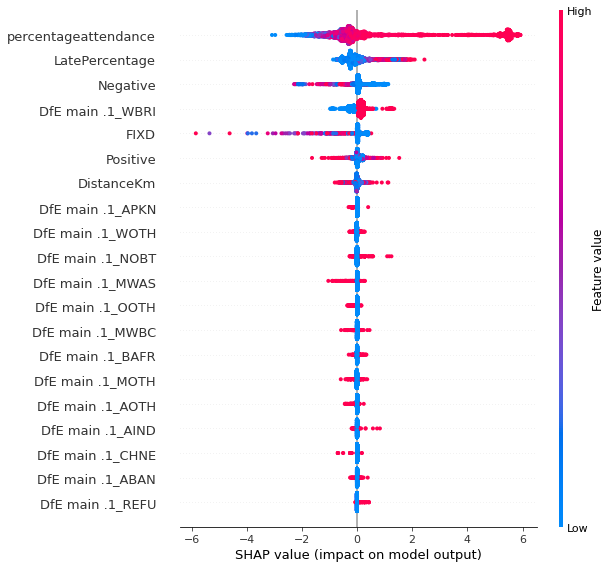

In [125]:
shap.summary_plot(shap_values, features = X_val)

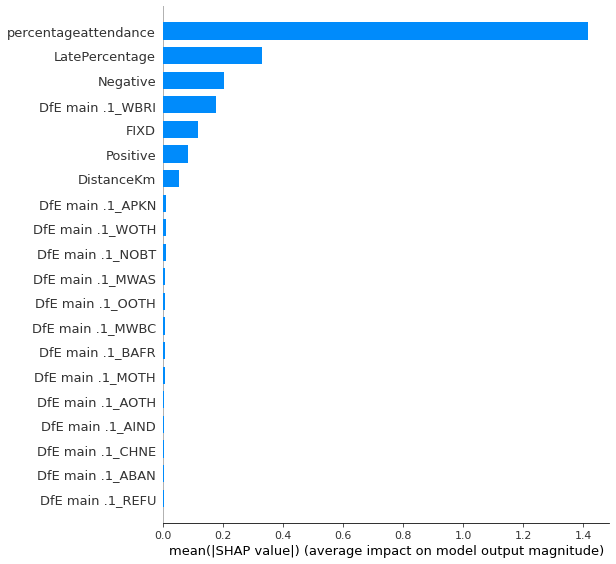

In [141]:
shap.summary_plot(shap_values, features = X_val, feature_names=X_val.columns, plot_type='bar')